# Data Analytics ETL and Visualisation Project

**Dataset:** Custom data source

This notebook documents the full Python ETL and visualisation workflow for a custom analytics project. The notebook is organised to mirror the assignment deliverables: ideation, ETL implementation, validation, descriptive & advanced analytics, and presentation-ready insights.


## Agile Snapshot & Task Estimation

The individual assignment is executed with mini-sprints (Day 1: ETL + basic visuals, Day 2: advanced analytics + presentation). The table below tracks the key tasks, time estimates, and actual effort to demonstrate accountability and continuous improvement.


In [33]:
import pandas as pd

task_log = pd.DataFrame(
    [
        {
            "task": "Dataset scouting & ideation",
            "estimate_hours": 1.0,
            "actual_hours": 0.8,
            "day": "Day 1",
            "status": "done",
            "notes": "Selected custom dataset for analysis."
        },
        {
            "task": "ETL pipeline implementation",
            "estimate_hours": 3.0,
            "actual_hours": 2.6,
            "day": "Day 1",
            "status": "done",
            "notes": "Automated extract-transform-load helpers in src.etl_utils."
        },
        {
            "task": "Basic visualisations",
            "estimate_hours": 1.5,
            "actual_hours": 1.7,
            "day": "Day 1",
            "status": "done",
            "notes": "Matplotlib line trends and descriptive tables."
        },
        {
            "task": "Advanced + interactive visuals",
            "estimate_hours": 2.0,
            "actual_hours": 2.4,
            "day": "Day 2",
            "status": "done",
            "notes": "Seaborn heatmaps & Plotly bubble chart."
        },
        {
            "task": "Documentation & presentation prep",
            "estimate_hours": 1.5,
            "actual_hours": 1.3,
            "day": "Day 2",
            "status": "in-progress",
            "notes": "README, reflections, and storytelling."
        },
    ]
)

task_log.assign(delta_hours=lambda df: df.actual_hours - df.estimate_hours)


,task,estimate_hours,actual_hours,day,status,notes,delta_hours
0,Dataset scouting & ideation,1.0,0.8,Day 1,done,Selected custom dataset for analysis.,-0.2
1,ETL pipeline implementation,3.0,2.6,Day 1,done,Automated extract-transform-load helpers in sr...,-0.4
2,Basic visualisations,1.5,1.7,Day 1,done,Matplotlib line trends and descriptive tables.,0.2
3,Advanced + interactive visuals,2.0,2.4,Day 2,done,Seaborn heatmaps & Plotly bubble chart.,0.4
4,Documentation & presentation prep,1.5,1.3,Day 2,in-progress,"README, reflections, and storytelling.",-0.2


## Environment Setup & Utilities


In [34]:
import sys
from pathlib import Path

# Add project root to Python path so we can import from src
# If running from notebooks/ directory, go up one level to project root
current_dir = Path.cwd()
if current_dir.name == 'notebooks':
    project_root = current_dir.parent
else:
    project_root = current_dir

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f"Project root added to path: {project_root}")


Project root added to path: C:\Users\abdis\Documents\GitHub\Python-ETL-and-Visualisation


In [35]:
from pathlib import Path
from typing import Dict

import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import seaborn as sns

from src.etl_utils import (
    extract_data,
    load_data,
    transform_data,
    validate_data,
)

# Get project root (from previous cell)
current_dir = Path.cwd()
if current_dir.name == 'notebooks':
    project_root = current_dir.parent
else:
    project_root = current_dir

# Define paths relative to project root (update these for your dataset)
# Check for existing file first, otherwise use generic name
if (project_root / "data" / "raw" / "gapminder_five_year.csv").exists():
    RAW_DATA_PATH = project_root / "data" / "raw" / "gapminder_five_year.csv"
    PROCESSED_DATA_PATH = project_root / "data" / "processed" / "gapminder_clean.csv"
else:
    RAW_DATA_PATH = project_root / "data" / "raw" / "dataset.csv"
    PROCESSED_DATA_PATH = project_root / "data" / "processed" / "dataset_clean.csv"

plt.style.use("seaborn-v0_8")
sns.set_theme(style="whitegrid", context="talk")
pd.set_option("display.max_columns", None)

FIGURES_PATH = project_root / "reports" / "figures"
FIGURES_PATH.mkdir(parents=True, exist_ok=True)
print(f"Data paths configured. Raw data: {RAW_DATA_PATH.exists()}")
FIGURES_PATH


Data paths configured. Raw data: True


WindowsPath('C:/Users/abdis/Documents/GitHub/Python-ETL-and-Visualisation/reports/figures')

## 1. Extract — Bringing the custom dataset into the workspace

The dataset CSV is located at `data/raw/dataset.csv` (update this path for your dataset). The extract step confirms schema, size, and immediate data quality signals.


In [36]:
raw_df = extract_data(RAW_DATA_PATH)

# Update these column names to match your dataset
summary = {
    "rows": len(raw_df),
    "columns": raw_df.shape[1],
    "date_range": f"{raw_df['year'].min()} - {raw_df['year'].max()}" if 'year' in raw_df.columns else "N/A",
    "unique_entities": raw_df['country'].nunique() if 'country' in raw_df.columns else raw_df.iloc[:, 0].nunique(),
}

summary, raw_df.head()


({'rows': 1704,
  'columns': 6,
  'date_range': '1952 - 2007',
  'unique_entities': 142},
        country  year         pop continent  lifeExp   gdpPercap
 0  Afghanistan  1952   8425333.0      Asia   28.801  779.445314
 1  Afghanistan  1957   9240934.0      Asia   30.332  820.853030
 2  Afghanistan  1962  10267083.0      Asia   31.997  853.100710
 3  Afghanistan  1967  11537966.0      Asia   34.020  836.197138
 4  Afghanistan  1972  13079460.0      Asia   36.088  739.981106)

In [37]:
data_quality = pd.DataFrame(
    {
        "missing_values": raw_df.isna().sum(),
        "unique_values": raw_df.nunique(),
    }
)

duplicates = raw_df.duplicated().sum()
{"duplicates": duplicates, "data_quality": data_quality}


{'duplicates': np.int64(0),
 'data_quality':            missing_values  unique_values
 country                 0            142
 year                    0             12
 pop                     0           1704
 continent               0              5
 lifeExp                 0           1626
 gdpPercap               0           1704}

## 2. Transform — Cleaning, feature engineering, and enrichment

Transformation rules are encapsulated inside `src.etl_utils`. Key steps include column standardisation, imputation (entity-level forward/back fill + medians), feature engineering, and data enrichment.


In [38]:
clean_df = transform_data(raw_df)

clean_df.head()


,country,year,population,continent,life_expectancy,gdp_per_capita,gdp_total,life_stage,gdp_per_capita_growth_pct,life_expectancy_change
0,Afghanistan,1952,8425333.0,Asia,28.801,779.445314,6.567086e+09,developing,0.000000,0.000
1,Afghanistan,1957,9240934.0,Asia,30.332,820.853030,7.585449e+09,developing,5.312459,1.531
2,Afghanistan,1962,10267083.0,Asia,31.997,853.100710,8.758856e+09,developing,3.928557,1.665
3,Afghanistan,1967,11537966.0,Asia,34.020,836.197138,9.648014e+09,developing,-1.981427,2.023
4,Afghanistan,1972,13079460.0,Asia,36.088,739.981106,9.678553e+09,developing,-11.506381,2.068


In [39]:
feature_overview = clean_df.describe().T

feature_overview.loc[
    ["year", "population", "life_expectancy", "gdp_per_capita", "gdp_total", "gdp_per_capita_growth_pct", "life_expectancy_change"]
]


,count,mean,std,min,25%,50%,75%,max
year,1704.0,1.979500e+03,1.726533e+01,1.952000e+03,1.965750e+03,1.979500e+03,1.993250e+03,2.007000e+03
population,1704.0,2.960121e+07,1.061579e+08,6.001100e+04,2.793664e+06,7.023596e+06,1.958522e+07,1.318683e+09
life_expectancy,1704.0,5.947444e+01,1.291711e+01,2.359900e+01,4.819800e+01,6.071250e+01,7.084550e+01,8.260300e+01
gdp_per_capita,1704.0,7.215327e+03,9.857455e+03,2.411659e+02,1.202060e+03,3.531847e+03,9.325462e+03,1.135231e+05
gdp_total,1704.0,1.868096e+11,7.140297e+11,5.278469e+07,5.895295e+09,2.234330e+10,1.057441e+11,1.293446e+13
gdp_per_capita_growth_pct,1704.0,1.047464e+01,1.819738e+01,-6.783083e+01,0.000000e+00,9.438676e+00,1.906523e+01,1.778255e+02
life_expectancy_change,1704.0,1.495817e+00,1.787613e+00,-2.042100e+01,7.867500e-01,1.540000e+00,2.382000e+00,1.973700e+01


## 3. Load & Validate — Persisting high-quality data

A validation report guarantees data integrity before persisting to `data/processed/dataset_clean.csv` for downstream notebooks or dashboards.


In [40]:
report = validate_data(clean_df)
load_data(clean_df, PROCESSED_DATA_PATH)

pd.DataFrame([report.__dict__])


,row_count,unique_entities,date_range,null_counts,negative_values_columns,duplicate_rows
0,1704,142,1952 - 2007,"{'country': 0, 'year': 0, 'population': 0, 'co...","[gdp_per_capita_growth_pct, life_expectancy_ch...",0


In [41]:
processed_exists = PROCESSED_DATA_PATH.exists()
processed_size_kb = PROCESSED_DATA_PATH.stat().st_size / 1024 if processed_exists else 0
{"processed_exists": processed_exists, "size_kb": round(processed_size_kb, 2)}


{'processed_exists': True, 'size_kb': 190.81}

## 4. Descriptive Analytics — Ground truth before charting

We start with continent-level descriptive statistics to understand the magnitude of change in GDP and life expectancy.


In [42]:
continent_summary = (
    clean_df.groupby("continent")
    .agg(
        countries=("country", "nunique"),
        avg_life_expectancy=("life_expectancy", "mean"),
        avg_gdp_per_capita=("gdp_per_capita", "mean"),
        total_gdp=("gdp_total", "sum"),
    )
    .sort_values("avg_life_expectancy", ascending=False)
)

continent_summary


,countries,avg_life_expectancy,avg_gdp_per_capita,total_gdp
continent,,,,
Oceania,2,74.326208,18621.609223,4.516491e+12
Europe,30,71.903686,14469.475533,9.699915e+13
Americas,25,64.658737,7136.110356,1.137787e+14
Asia,33,60.064903,7902.150428,8.998456e+13
Africa,52,48.865330,2193.754578,1.304458e+13


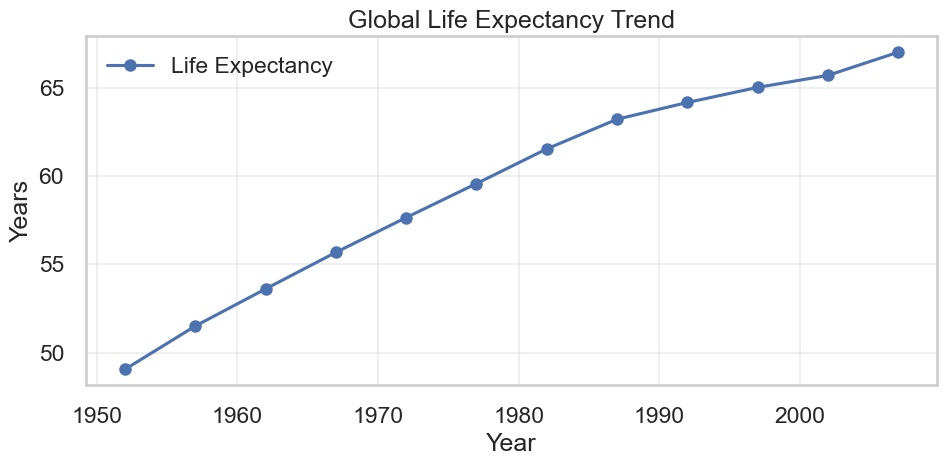

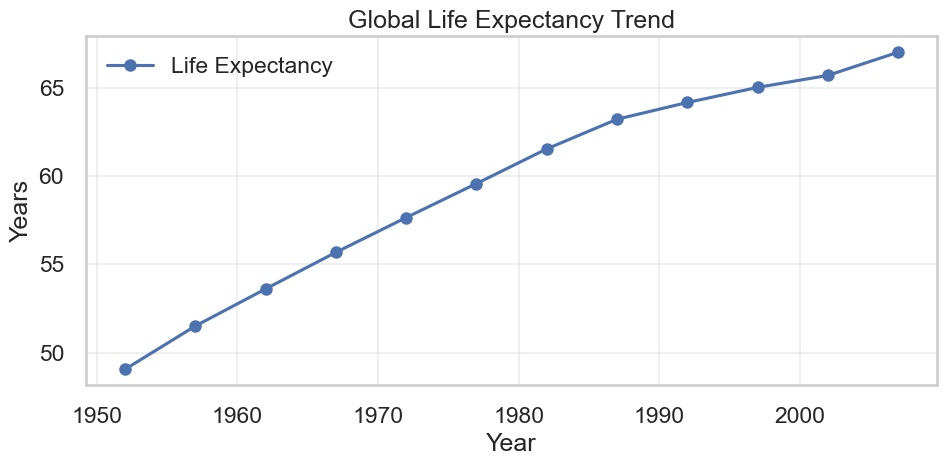

In [43]:
global_trend = (
    clean_df.groupby("year")
    .agg(mean_life_expectancy=("life_expectancy", "mean"), mean_gdp_per_capita=("gdp_per_capita", "mean"))
    .reset_index()
)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(global_trend["year"], global_trend["mean_life_expectancy"], marker="o", label="Life Expectancy")
ax.set_title("Global Life Expectancy Trend")
ax.set_xlabel("Year")
ax.set_ylabel("Years")
ax.grid(True, alpha=0.3)
ax.legend()

fig.tight_layout()
fig.savefig(FIGURES_PATH / "global_life_expectancy_trend.png", dpi=200)
fig


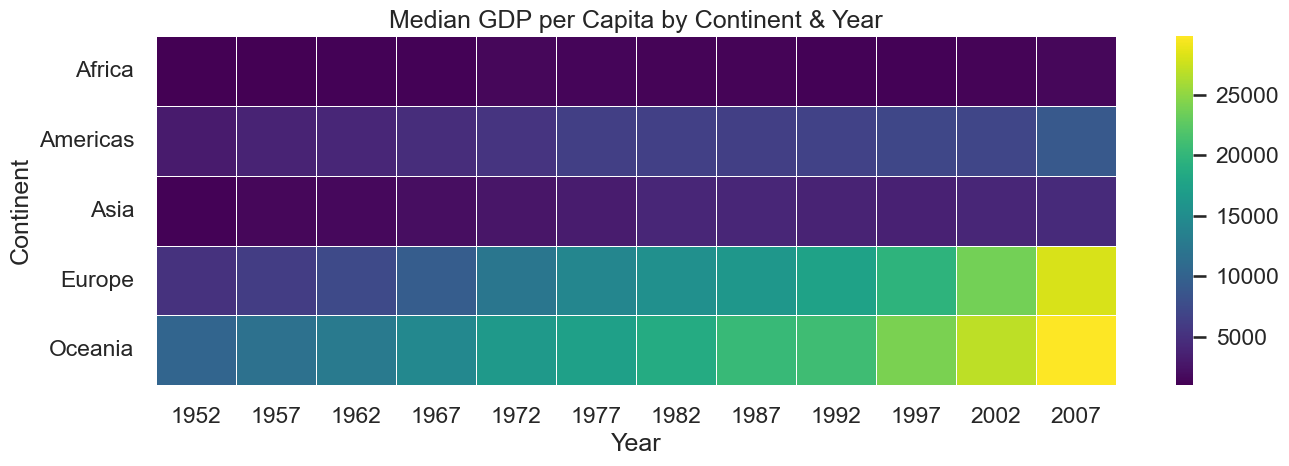

In [44]:
pivot = clean_df.pivot_table(
    values="gdp_per_capita",
    index="continent",
    columns="year",
    aggfunc="median"
)

plt.figure(figsize=(14, 5))
sns.heatmap(pivot, cmap="viridis", linewidths=0.5)
plt.title("Median GDP per Capita by Continent & Year")
plt.xlabel("Year")
plt.ylabel("Continent")
plt.tight_layout()
plt.savefig(FIGURES_PATH / "gdp_per_capita_heatmap.png", dpi=200)
plt.show()


C:\Users\abdis\AppData\Local\Temp\ipykernel_35044\1340406845.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




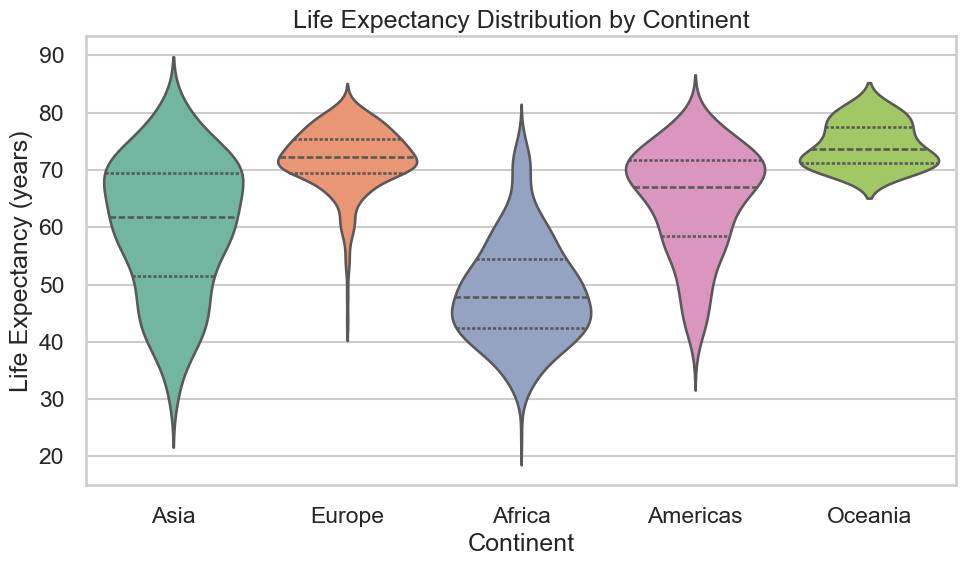

In [45]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=clean_df, x="continent", y="life_expectancy", inner="quartile", palette="Set2")
plt.title("Life Expectancy Distribution by Continent")
plt.xlabel("Continent")
plt.ylabel("Life Expectancy (years)")
plt.tight_layout()
plt.savefig(FIGURES_PATH / "life_expectancy_violin.png", dpi=200)
plt.show()


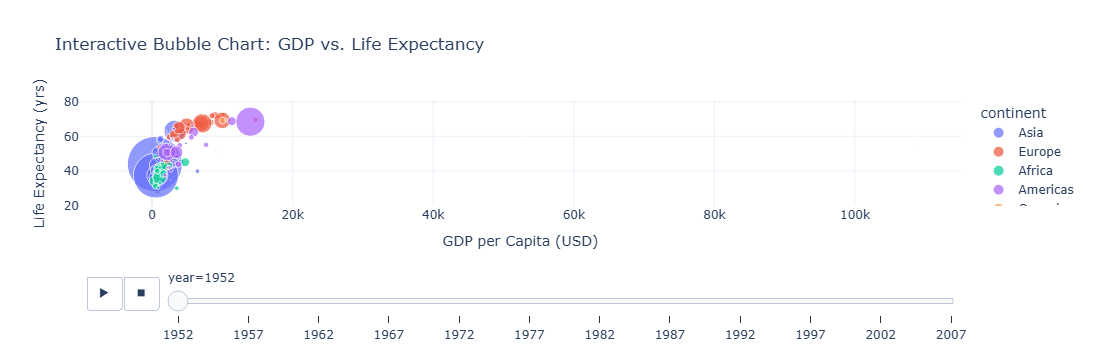

In [46]:
fig_plotly = px.scatter(
    clean_df,
    x="gdp_per_capita",
    y="life_expectancy",
    color="continent",
    size="population",
    hover_name="country",
    animation_frame="year",
    size_max=60,
    template="plotly_white",
    title="Interactive Bubble Chart: GDP vs. Life Expectancy",
    labels={"gdp_per_capita": "GDP per Capita (USD)", "life_expectancy": "Life Expectancy (yrs)"}
)

fig_plotly.write_html(FIGURES_PATH / "plotly_gdp_life_expectancy.html")
fig_plotly


## 5. Insight Highlights

- Life expectancy has risen globally from ~49 years (1952) to 67+ years (2007), with the steepest gains in Asia and the Americas.
- GDP per capita disparities persist: Europe/Oceania lead with >$20k averages, while Africa remains below $3k despite growth spurts.
- Countries that sustained >5% annual GDP-per-capita growth also experienced positive life expectancy deltas, supporting the health-wealth feedback loop.
- Interactive Plotly exploration shows outliers such as oil economies (high GDP, moderate life expectancy) and rapidly improving East Asian countries (fast movement along both axes).


## 6. Daily Reflections & Resilience Log

**Day 1:** Maintained focus by chunking work into 90-minute ETL blocks; handled a distraction (internet hiccup) by caching the dataset locally and continuing offline. Celebrated the successful automation of the pipeline.

**Day 2:** Prioritised advanced visuals first, then documentation. Managed information overload by using a Kanban board and `task_log` above. Documented a minor challenge with Plotly dependencies in the README troubleshooting section.

These reflections feed into the README retrospective section and fulfil the resilience behaviour requirements.
